# OPTIMIZAR GASTOS DE MARKETING EN LA COMPAÑIA Y.Afisha #

En este proyecto tengo registros de visitas, registros de pedidos y gastos de marketing para el período del 1.6.2017 al 31.5.2018. Usando los datos que contienen, voy a analizar el comportamiento de los usuarios, los patrones de visitas y pedidos para diferentes categorías de usuarios y calcular diferentes métricas, como se describe a continuación.

El objetivo principal del proyecto es analizar estos datos y sacar conclusiones sobre las inversiones en marketing: qué inversiones, cuándo y en qué grupo de usuarios dan mejores resultados que otros, en qué debería concentrarse el equipo de marketing y qué necesita más mejoras. Al final del proyecto, resumiré los resultados y proporcionaré mis recomendaciones.

**Tenemos los siguientes datos**  :

- Registros del servidor con datos sobre las visitas a Y.Afisha desde enero de
- 2017 hasta diciembre de 2018
- Archivo de volcado con todos los pedidos del período
- Estadísticas de gastos de marketing


**Objetivo de analisis del proyecto** :
- Cómo la gente usa el producto
- Cuándo empiezan a comprar
- Cuánto dinero trae cada cliente
- Cuándo pagan

**Descripcion de los datos** :

La tabla visits (registros del servidor con datos sobre las visitas al sitio web):

- Uid — identificador único del usuario
- Device — dispositivo del usuario
- Start Ts — fecha y hora de inicio de la sesión
- End Ts — fecha y hora de término de la sesión
- Source Id — identificador de la fuente de anuncios de la que proviene el usuario

La tabla orders (datos sobre pedidos):

- Uid — identificador único del usuario que realiza un pedido
- Buy Ts — fecha y hora del pedido
- Revenue — Ingresos de Y.Afisha de este pedido

La tabla costs (datos sobre gastos de marketing):

- source_id — identificador de la fuente de anuncios
- dt — fecha
- costs — gastos en esta fuente de anuncios en este día

## 01. Iniciacion ## 

Carga de librerias y datos

In [1]:
#Cargaremos las librerias 
!pip install missingno
import pandas as pd
import matplotlib.pyplot as plt #Creacion de graficos
import seaborn as sns  # Visualizacion de datos
import numpy as np  # Calculo matematico y estadistico 
import missingno as msno
from scipy.stats import ttest_ind  #  realiza una prueba t de dos muestras independientes. 

In [2]:
#Carga de datos

try: #anaconda
    cost = pd.read_csv('costs_us.csv' ,parse_dates=['dt'])

    order = pd.read_csv('orders_log_us.csv',parse_dates=['Buy Ts'] )
    
    visits = pd.read_csv('visits_log_us.csv', parse_dates=['End Ts', 'Start Ts']  ,dtype= {'Device': 'category'} )
    
except: #jupyter
    cost = pd.read_csv('/datasets/costs_us.csv',parse_dates=['dt'])
    
    order = pd.read_csv('/datasets/orders_log_us.csv',  parse_dates=['Buy Ts'])
    
    visits = pd.read_csv('/datasets/visits_log_us.csv',  parse_dates=['End Ts', 'Start Ts'],dtype= {'Device': 'category'} )

In [3]:
# Carga de funciones establecidas

def data_info(df):
    print('Analisis de datos de la tabla')
    print('Filas y columnas: \n{}'.format(df.shape))
    print('*' * 50)
    print('Informacion general:')
    print(df.info())
    print('*' * 50)
    print('Primeras cinco columnas: \n{}'.format(df.head()))
    print('*' * 50)
    print('Detalles estadisticos: \n{}'.format(df.describe()))
    print('*' * 50)
    print('Cuantos duplicados hay?\n')
    print('Hay {} datos duplicados.'.format(df.duplicated().sum()))
    print('*' * 50)
    print('Valores ausentes ?')
    print(df.isna().sum(),'\n')
    print('Porcentaje de valores ausentes \n')
    print(df.isna().mean().reset_index())
    print('*' * 50)
    print('Distribucion de valores ausentes \n')
    print((df.isna()
 .sum()
 .sort_values(ascending=False)
 .reset_index()
 .rename(columns = {'index' : 'Variables', 0: 'Missing'})
).T)

In [4]:
#Funcion que separa la fecha por dia mes y año

def get_date(df): 
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns if 'date' in x][0]
    
    df[columns[idx]] = pd.to_datetime(df[columns[idx]])
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year

In [5]:
# Funcion para convertir todas las columnas y celdas a minuscula 


def convertir_a_minusculas(df):
    """
    Convierte todas las columnas de un DataFrame a minúsculas utilizando applymap y str.lower().
    También modifica los nombres de las columnas a minúsculas.
    
    Args:
    df (pandas.DataFrame): El DataFrame a convertir.
    
    Returns:
    pandas.DataFrame: El DataFrame con todas las columnas en minúsculas y con nombres de columna en minúsculas.
    """
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    df.columns = df.columns.str.lower()
    return df

 ## 02.  Exploracion de datos ###

### `Tabla Cost`:

La tabla costs (datos sobre gastos de marketing):
    
- source_id — identificador de la fuente de anuncios

- dt — fecha

- costs — gastos en esta fuente de anuncios en este día

In [6]:
data_info(cost)

Analisis de datos de la tabla
Filas y columnas: 
(2542, 3)
**************************************************
Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None
**************************************************
Primeras cinco columnas: 
   source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08
**************************************************
Detalles estadisticos: 
         source_id        costs
count  2542.000000  2542.000000
mean      4.857199   129.477427
std       3.181581 

In [7]:
# Con una funcion convertimos todo las columnas y celdas a minuscula

cost = convertir_a_minusculas(cost)



**Conclusion General**

De los datos podemos concluir lo siguiente:
- No hay valores duplicados
- No hay valores ausentes
- Se cargaron solo 500 datos de la base para evitar problemas de subrecarga
- Los nombres de las columnas estan correctas
-  Se modifico el formato de la columna  dt por "datetime"

### `Tabla order`:

La tabla orders (datos sobre pedidos):
    
- Uid — identificador único del usuario que realiza un pedido
- Buy Ts — fecha y hora del pedido
- Revenue — Ingresos de Y.Afisha de este pedido

In [8]:
data_info(order)

Analisis de datos de la tabla
Filas y columnas: 
(50415, 3)
**************************************************
Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
**************************************************
Primeras cinco columnas: 
               Buy Ts  Revenue                   Uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450
**************************************************
Detalles estad

In [9]:
# Con una funcion convertimos todo las columnas y celdas a minuscula

order = convertir_a_minusculas(order)

**Conclusion General**

De los datos podemos concluir lo siguiente:

- No hay valores duplicados
- No hay valores ausentes
- Se cargaron solo 500 datos de la base para evitar problemas de subrecarga
- Se modificó todo el contenido a minuscula
-  Se modifico el formato de la columna Buy Ts por "datetime"

### `Tabla Visits`:

La tabla visits (registros del servidor con datos sobre las visitas al sitio web):
    
- Uid — identificador único del usuario
- Device — dispositivo del usuario
- Start Ts — fecha y hora de inicio de la sesión
- End Ts — fecha y hora de término de la sesión
- Source Id — identificador de la fuente de anuncios de la que proviene el usuario

In [10]:
data_info(visits)

Analisis de datos de la tabla
Filas y columnas: 
(359400, 5)
**************************************************
Informacion general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
None
**************************************************
Primeras cinco columnas: 
    Device              End Ts  Source Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00 

In [11]:
visits.head(20)


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [12]:
# Con una funcion convertimos todo las columnas y celdas a minuscula

#visits = convertir_a_minusculas(visits)

# rename columns:

visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
order.columns = ['buy_ts', 'revenue', 'uid']

**Conclusion General**

De los datos podemos concluir lo siguiente:
- No hay valores duplicados
- No hay valores ausentes
- Se cargaron solo 500 datos de la base para evitar problemas de subrecarga
- Se modificaron todas las columnas y celdas a minuscula
-  Se modifico el formato de la columna  end ts y start ts   por "datetime" y device por " Category"

In [13]:
device_counts = visits['device'].value_counts()


print("Cantidad de dispositivos:")
print(device_counts)

# utiliza el método value_counts() para obtener la cantidad de veces que aparece cada valor en la columna 'source_id'
source_counts = visits['source_id'].value_counts()

print("Cantidad de fuentes de tráfico:")
print(source_counts)

Cantidad de dispositivos:
desktop    262567
touch       96833
Name: device, dtype: int64
Cantidad de fuentes de tráfico:
4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64


## 03. Informes y Metricas

### 01.Producto 

#### ¿Cuántas personas lo usan cada día, semana y mes?

In [14]:
# Creamos una columna por dia - semana y mes


visits['visits_year'] = visits['start_ts'].dt.year
visits['visits_month'] = visits['start_ts'].astype('datetime64[M]')
visits['visits_week'] = visits['start_ts'].astype('datetime64[W]')
visits['visits_date'] = visits['start_ts'].dt.date

# look at the result:
visits.tail(4)

,device,end_ts,source_id,start_ts,uid,visits_year,visits_month,visits_week,visits_date
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,2018-01-01,2018-01-25,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,2018-03-01,2018-03-01,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,2017-11-01,2017-11-02,2017-11-02
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559,2017,2017-09-01,2017-09-07,2017-09-10


In [15]:
# Calcular los usuarios activos diarios, semanal y mensual 


mau = visits.groupby('visits_month').agg({'uid': 'nunique'}).mean()
dau = visits.groupby('visits_date').agg({'uid': 'nunique'}).mean()
wau = visits.groupby('visits_week').agg({'uid': 'nunique'}).mean()

# Promedio 


print('El promedio de usuarios conectados diaramiente es  (DAU) ', int(dau))
print('El promedio de usuarios conectados semanalmente es (WAU) ', int(wau))
print('El promedio de usuarios conectados anualmente es (MAU) ', int(mau))

El promedio de usuarios conectados diaramiente es  (DAU)  907
El promedio de usuarios conectados semanalmente es (WAU)  5724
El promedio de usuarios conectados anualmente es (MAU)  23228


In [16]:
#Formacion de tabla dinamica para cada uno

dau = visits.groupby('visits_date').agg({'uid':'nunique'})
wau = visits.groupby('visits_week').agg({'uid':'nunique', 'visits_date':'nunique'}).query('visits_date >= 6').uid
mau = visits.groupby('visits_month').agg({'uid':'nunique'})

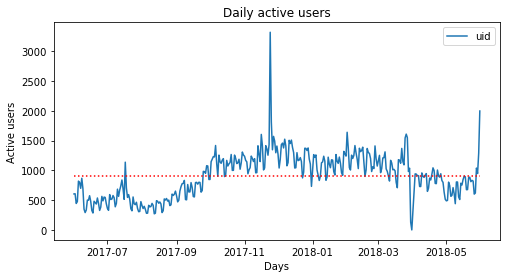

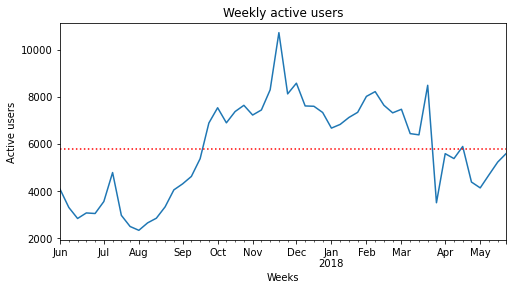

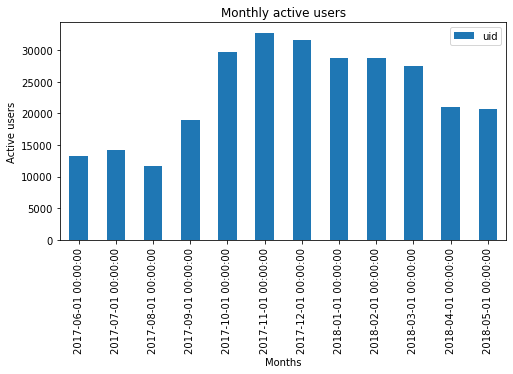

In [17]:
#Creacion de graficos para analizar el comportamiento de los usuarios, diario, semanal y mensual

dau.plot(figsize = (8,4))
plt.ylabel('Active users')
plt.xlabel('Days')
plt.title('Daily active users')
plt.hlines(int(dau.mean()), visits['visits_date'].min(), visits['visits_date'].max(), color='red', linestyle='dotted')
plt.show()

wau.plot(figsize = (8,4))
plt.ylabel('Active users')
plt.xlabel('Weeks')
plt.title('Weekly active users')
plt.hlines(int(wau.mean()), visits['visits_week'].min(), visits['visits_week'].max(), color='red', linestyle='dotted')

plt.show()

mau.plot(figsize = (8,4), kind = 'bar')
plt.ylabel('Active users')
plt.xlabel('Months')
plt.title('Monthly active users')
plt.hlines(int(mau.mean()), visits['visits_month'].min(), visits['visits_month'].max(), color='red', linestyle='dotted')
plt.show()

##### **Conclusion General**
En promedio los usuarios conetados;

- Diariamente: 907 
- Semanalmente 5717
- Mensualemte: 23228

MAU refleja cómo la actividad de los usuarios se ve afectada por la estacionalidad

El número de usuarios activos alcanzó su punto máximo en noviembre. Luego comenzó a disminuir, con algunos picos observados en el número más reciente de DAU. Debido a que DAU es más sensible a los detalles y puede detectar cambios día a día, podría reflejar un aumento repentino en nuevos usuarios debido a un nuevo enfoque de marketing u otros cambios.

La dinámica del factor de retención no parece ser lo suficientemente informativa. Parece que la caída en DAU y MAU fue simultánea, por lo que las tasas no cambiaron.

#### ¿Cuántas sesiones hay por día?

In [18]:
daily_sessions= visits.groupby('visits_date').agg({'uid': 'count'})

In [19]:
daily_sessions = visits.groupby('visits_date')['uid'].nunique().reset_index()
daily_sessions 

,visits_date,uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820
...,...,...
359,2018-05-27,620
360,2018-05-28,1039
361,2018-05-29,948
362,2018-05-30,1289


In [20]:
dau = visits.groupby('visits_date')['uid'].nunique().reset_index()
dau

,visits_date,uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820
...,...,...
359,2018-05-27,620
360,2018-05-28,1039
361,2018-05-29,948
362,2018-05-30,1289


In [21]:
print('Promedio de sesiones por dia es ', int(daily_sessions.mean()))
print('El promedio de las sesiones diarias y DAU es de ', round(float((int(daily_sessions.mean()) / dau.mean())), 2))

Promedio de sesiones por dia es  907
El promedio de las sesiones diarias y DAU es de  1.0


C:\Users\clara\AppData\Local\Temp\ipykernel_30156\4253029093.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('Promedio de sesiones por dia es ', int(daily_sessions.mean()))
C:\Users\clara\AppData\Local\Temp\ipykernel_30156\4253029093.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('El promedio de las sesiones diarias y DAU es de ', round(float((int(daily_sessions.mean()) / dau.mean())), 2))


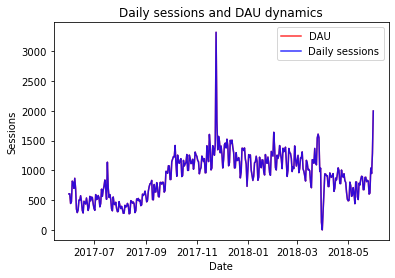

In [22]:
# Comparar grafico dau y Daily day

plt.plot(dau['visits_date'], dau['uid'], alpha = 0.8, label = 'DAU', color = 'red')
plt.plot(daily_sessions['visits_date'], daily_sessions['uid'], alpha = 0.8, label = 'Daily sessions', color='blue')

# Personalizar Grafico 

plt.legend()
plt.ylabel('Sessions')
plt.xlabel('Date')
plt.title('Daily sessions and DAU dynamics')
plt.show()

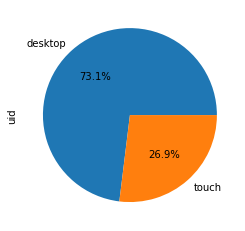

In [23]:
# Ingreso diario por plataforma 

daily_sessions_by_platform = visits.groupby('device').agg({'uid':'count'})
daily_sessions_by_platform.plot(kind = 'pie', subplots = 'True', autopct='%1.1f%%', legend = False)
plt.show()

##### **Conclusion General**

#### ¿Cuál es la duración de cada sesión?

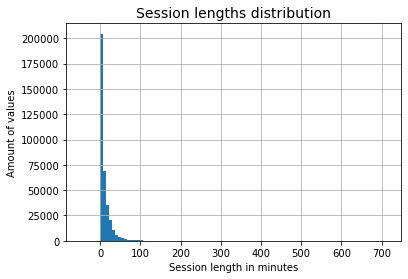

In [24]:
#Creamos un histograma para analizar como se distribuye el tiempo 


visits['session_length'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60

visits.session_length.hist(bins = 100)
plt.xlabel('Session length in minutes')
plt.ylabel('Amount of values')
plt.title('Session lengths distribution', fontsize = 14)
plt.show()

In [25]:

visits.query('session_length < 0')

,device,end_ts,source_id,start_ts,uid,visits_year,visits_month,visits_week,visits_date,session_length
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018,2018-03-01,2018-03-22,2018-03-25,-32.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018,2018-03-01,2018-03-22,2018-03-25,-46.0


In [26]:
print('Total de visitas con una duracion de 0 o menos : {:.2%}'.format(
    len(visits.query('session_length <= 0')) / len(visits)))

Total de visitas con una duracion de 0 o menos : 9.96%


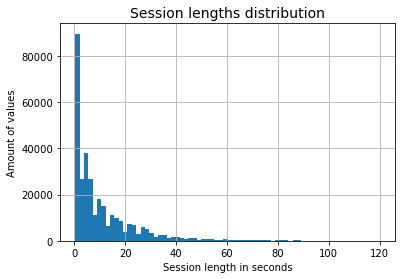

In [27]:
# Removeremos los valores atipicos, donde tienen una duracion igual o menor de 0 y mayor de dos horas:
visits = visits.query('0 < session_length <= 120')

# Graficar histograma:

visits.session_length.hist(bins = 70)
plt.xlabel('Session length in seconds')
plt.ylabel('Amount of values')
plt.title('Session lengths distribution', fontsize = 14)
plt.show()

In [28]:
average_session = visits.groupby('visits_date').agg({'session_length':'median'})
print('Promedio de duracion de las sesiones es de  {} minutes'.format(int(average_session.median())))

Promedio de duracion de las sesiones es de  6 minutes


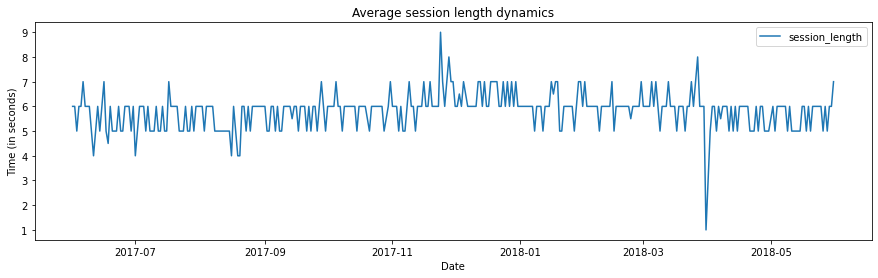

In [29]:
# duracion promedio 

average_session .plot(figsize = (15,4))
plt.ylabel('Time (in seconds)')
plt.xlabel('Date')
plt.title('Average session length dynamics')
plt.show()

##### **Conclusion General**

- La duracion proemdio de las sesiones es de 6 minutos
-  hay casi un 10% de usuarios que su duracione es de 0 segundos, con esto podemos decir que abren la pagina y la cierran enseguida
- la duracion es de las sesiones se mantiene, excepto en algunas ocaciones que representa caidas extremas, como en abril del 2018. o subidas como en dicimebre del 2017

#### ¿Con qué frecuencia los usuarios y las usuarias regresan?

In [30]:
visits

,device,end_ts,source_id,start_ts,uid,visits_year,visits_month,visits_week,visits_date,session_length
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-14,2017-12-20,18.000000
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-15,2018-02-19,28.000000
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-17,2018-05-20,24.000000
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,2017-08-31,2017-09-03,1.000000
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01-01,2018-01-25,2018-01-30,56.000000
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,2017-07-01,2017-07-27,2017-07-29,0.316667
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,2018-01-01,2018-01-25,2018-01-25,0.316667
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,2018-03-01,2018-03-01,2018-03-03,0.316667
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,2017-11-01,2017-11-02,2017-11-02,0.316667


In [31]:
# Primera visita de cada usuario
first_activity_date = visits.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
user_activity = visits[['uid', 'start_ts', 'device', 'source_id']].join(first_activity_date, on = 'uid')

In [32]:
# Agregar la primera actividad en mes
user_activity['activity_month'] = user_activity['start_ts'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')

In [33]:
# Calculo de chocorto
user_activity['cohort_lifetime'] = (
    (user_activity['activity_month'] - user_activity['first_activity_month']) / np.timedelta64(1, 'M')).round().astype('int')

user_activity.head()

,uid,start_ts,device,source_id,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,16879256277535980062,2017-12-20 17:20:00,touch,4,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,104060357244891740,2018-02-19 16:53:00,desktop,2,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
3,16174680259334210214,2018-05-20 10:59:00,desktop,9,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
5,16007536194108375387,2017-09-03 21:35:00,desktop,5,2017-09-03 21:35:00,2017-09-01,2017-09-01,0
6,6661610529277171451,2018-01-30 11:13:00,desktop,1,2017-06-29 09:00:00,2018-01-01,2017-06-01,7


In [34]:
# Crart una tabla de cohorto
cohorts = user_activity.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid': 'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on = 'first_activity_month')

# Agregar una columna de retencion
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,11880,11880,1.000000
1,2017-06-01,1,899,11880,0.075673
2,2017-06-01,2,606,11880,0.051010
3,2017-06-01,3,710,11880,0.059764
4,2017-06-01,4,777,11880,0.065404


In [35]:
# Tabla dinamica 

cohorts_retention_pivot = cohorts.pivot_table(
    index = 'first_activity_month',
    columns = 'cohort_lifetime',
    values = 'retention',
    aggfunc = 'sum')

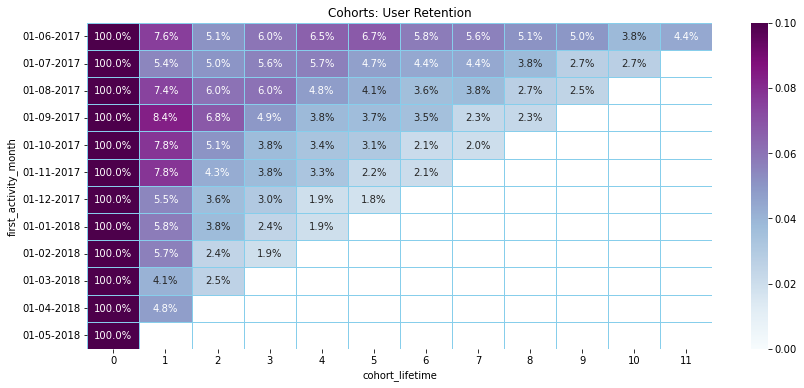

In [36]:
# Grafico 


plt.figure(figsize=(14, 6))
plt.title('Cohorts: User Retention')
sns.heatmap(
    cohorts_retention_pivot, 
    annot=True, 
    fmt='.1%', 
    linewidths=1, 
    linecolor='skyblue', 
    cmap = 'BuPu',
    vmin = 0, vmax = 0.1
).set_yticklabels(cohorts_retention_pivot.index.strftime('%d-%m-%Y'))
plt.show()

In [37]:
# Extraemos el primer ingreso por usuario :
first_source_id = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id':'first'})
first_source_id = first_source_id.rename(columns = {'source_id' : 'first_source_id'})

user_activity = user_activity.merge(first_source_id, on = 'uid')

In [38]:
# cohortos por fuentes de anuncios 
source_retention = user_activity.groupby(['first_source_id', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users_count = source_retention[source_retention['cohort_lifetime'] == 0][['first_source_id', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid': 'source_users'})
source_retention = source_retention.merge(initial_users_count, on = 'first_source_id')

# creamos una columna de retencion :
source_retention['retention'] = source_retention['uid'] / source_retention['source_users']

source_retention.head()

,first_source_id,cohort_lifetime,uid,source_users,retention
0,1,0,9299,9299,1.000000
1,1,1,912,9299,0.098075
2,1,2,526,9299,0.056565
3,1,3,397,9299,0.042693
4,1,4,322,9299,0.034627


In [39]:
#Tabla dinamica 

source_retention_pivot = source_retention.pivot_table(
    index = 'first_source_id',
    columns = 'cohort_lifetime',
    values = 'retention',
    aggfunc = 'sum')

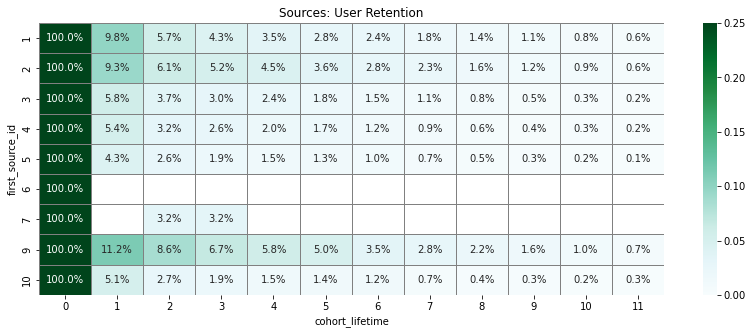

In [40]:
# mapa de calor de rentencio de usuarios 

plt.figure(figsize=(14, 5))
plt.title('Sources: User Retention')
sns.heatmap(
    source_retention_pivot, 
    annot=True, 
    fmt='.1%', 
    linewidths=1, 
    linecolor='gray', 
    cmap = 'BuGn',
    vmin = 0, vmax = 0.25
)
plt.show()

<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
    
Felicidades por dar un paso adicional y calcular la tasa de retención por fuente. 

</div>

In [41]:
# primera visita de usuario :
first_device = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'device':'first'})
first_device = first_device.rename(columns = {'device' : 'first_device'})

# la agregamos :
user_activity = user_activity.merge(first_device, on = 'uid')

In [42]:
# revisar retencion por plataforma :
device_retention = user_activity.groupby(['first_device', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
device_users_count = device_retention[device_retention['cohort_lifetime'] == 0][['first_device', 'uid']]
device_users_count = device_users_count.rename(columns = {'uid': 'device_users'})
device_retention = device_retention.merge(device_users_count, on = 'first_device')

# aregar columna de retencion :
device_retention['retention'] = device_retention['uid'] / device_retention['device_users']

device_retention.head()

,first_device,cohort_lifetime,uid,device_users,retention
0,desktop,0,147358,147358,1.000000
1,desktop,1,9014,147358,0.061171
2,desktop,2,5722,147358,0.038831
3,desktop,3,4641,147358,0.031495
4,desktop,4,3785,147358,0.025686


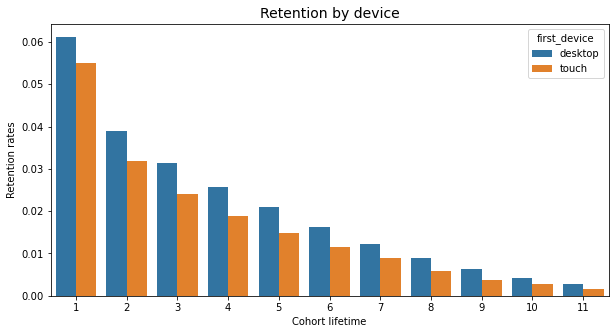

In [43]:
# Creamos un grafico que represente mediante que dispositivo se ingresa por cohorto 

plt.figure(figsize = (10,5))
sns.barplot(data = device_retention.query('cohort_lifetime > 0'), x = 'cohort_lifetime', y = 'retention', hue = 'first_device')
plt.ylabel('Retention rates')
plt.xlabel('Cohort lifetime')
plt.title('Retention by device', fontsize = 14)
plt.show()

In [44]:
visits_by_source = (user_activity.first_source_id.value_counts() / len(user_activity)).reset_index()
visits_by_source.columns = ['first_source_id', 'visits_share']
visits_by_source

,first_source_id,visits_share
0,4,0.285376
1,3,0.274846
2,5,0.187438
3,2,0.117226
4,1,0.070922
5,9,0.034906
6,10,0.029170
7,7,0.000105
8,6,0.000012


##### **Conclusion General**

En la mayoría de las cohortes, la retención tiende a ser significativamente menor después de un período de tiempo, excepto para la cohorte 6.7.

En cuanto a las fuentes, la mejor tasa de retención se encuentra en los identificadores numerados como 1, 2 y 9. Las tasas para las fuentes con los identificadores 6 y 7 no son representativas, ya que su porcentaje en el conjunto de datos general es insignificante.

La retención por dispositivo es consistentemente menor para los dispositivos táctiles.

### 02.Servicios

#### ¿Cuándo la gente empieza a comprar? 

En el análisis de KPI, generalmente nos interesa saber el tiempo que transcurre entre el registro y la conversión, es decir, cuando el/la usuario/a se convierte en cliente. Por ejemplo, si el registro y la primera compra ocurren el mismo día, el/la usuario/a podría caer en la categoría Conversion 0d. Si la primera compra ocurre al día siguiente, será Conversion 1d. Puedes usar cualquier enfoque que te permita comparar las conversiones de diferentes cohortes para que puedas determinar qué cohorte o canal de marketing es más efectivo

La tabla order contiene la fecha de compra de cada usuario

In [45]:
# Buscamos la primera compra de cada usuario 

conversion = order.groupby('uid').agg({'buy_ts':'first'}).reset_index()

# Lo agregamos a nuestra tabla
conversion = conversion.join(first_activity_date, on = 'uid')

# agregamos la plataforma 
conversion = conversion.merge(user_activity[['first_source_id', 'first_device', 'uid']], on = 'uid', how = 'left')

conversion['buy_ts'] = conversion['buy_ts'].dt.date
conversion['first_activity_date'] = conversion['first_activity_date'].dt.date

In [46]:
#creamos una colluma para calcular la conversion de dias entre la priemra visita y la compra 

conversion['conversion_days'] = (conversion['buy_ts'] - conversion['first_activity_date']).dt.days

# detectas los valroes negativos

len(conversion.query('conversion_days < 0'))


764

In [47]:
# Reemplazar la conversion negativa por cero

conversion.loc[conversion['conversion_days'] < 0, 'conversion_days'] = 0

len(conversion.query('conversion_days < 0'))

0

In [48]:
conversion

,uid,buy_ts,first_activity_date,first_source_id,first_device,conversion_days
0,313578113262317,2018-01-03,2017-09-18,2.0,desktop,107.0
1,313578113262317,2018-01-03,2017-09-18,2.0,desktop,107.0
2,313578113262317,2018-01-03,2017-09-18,2.0,desktop,107.0
3,1575281904278712,2017-06-03,2017-06-03,10.0,touch,0.0
4,1575281904278712,2017-06-03,2017-06-03,10.0,touch,0.0
...,...,...,...,...,...,...
91612,18446156210226471712,2018-02-18,2017-11-07,3.0,desktop,103.0
91613,18446156210226471712,2018-02-18,2017-11-07,3.0,desktop,103.0
91614,18446156210226471712,2018-02-18,2017-11-07,3.0,desktop,103.0
91615,18446167067214817906,2017-10-17,2017-10-17,5.0,desktop,0.0


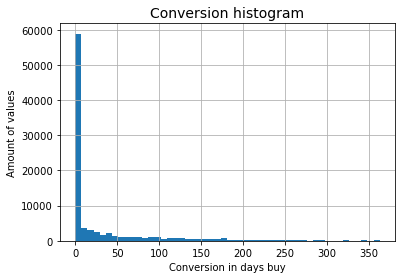

In [49]:
#  Graficar 


conversion.conversion_days.hist(bins = 50)
plt.ylabel('Amount of values')
plt.xlabel('Conversion in days buy')
plt.title('Conversion histogram', fontsize = 14)
plt.show()

In [50]:
print('El tiempo promedio de conversion es de  {:.2f} days'.format(conversion.conversion_days.mean()))

El tiempo promedio de conversion es de  31.66 days


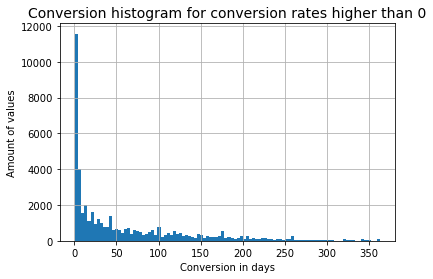

In [51]:
# Creamos un grafico pero excluyendo los valroes 0 :


conversion.query('conversion_days > 0').conversion_days.hist(bins = 100)
plt.ylabel('Amount of values')
plt.xlabel('Conversion in days')
plt.title('Conversion histogram for conversion rates higher than 0', fontsize = 14)
plt.show()

In [52]:
# cuantos usuarios tienen una conversionas 0

print('Total de usuarios que  tienen una conversion igual a 0: ', len(conversion.query('conversion_days == 0')))
print('El porcentaje de usuarios que se convertieron en compradores en el dia 0 es : {:.2%}'.format(len(conversion.query('conversion_days == 0')) / len(conversion)))

Total de usuarios que  tienen una conversion igual a 0:  43868
El porcentaje de usuarios que se convertieron en compradores en el dia 0 es : 47.88%


In [53]:
#Calculo de las medias de conversion 

print('El promedio de conversion es de  {:.2f} days'.format(conversion.conversion_days.median()))
print()
print('El pormedio de convercsion por dispositivo:')
print(conversion.groupby('first_device').conversion_days.median())
print()
print('Promedio de conversion por fuente de anuncio " source" :')
print(conversion.groupby('first_source_id').conversion_days.median())

El promedio de conversion es de  1.00 days

El pormedio de convercsion por dispositivo:
first_device
desktop    1.0
touch      1.0
Name: conversion_days, dtype: float64

Promedio de conversion por fuente de anuncio " source" :
first_source_id
1.0      1.0
2.0      4.0
3.0      1.0
4.0      0.0
5.0      0.0
7.0      0.0
9.0     15.0
10.0     0.0
Name: conversion_days, dtype: float64


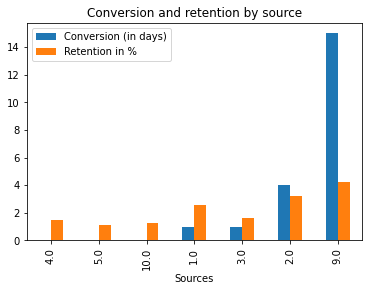

In [54]:
# Comparar conversion y retencion por la fuente de anuncio

sources_compare = pd.concat([conversion.groupby('first_source_id').conversion_days.median(), 
                             #convert retention to %
                    round((source_retention.groupby('first_source_id').retention.median() * 100), 2)], axis = 1)


# Excluimos el anuncio 6 y 7 porque no tiene informacion suficiente 
sources_compare.query('index != 6 & index != 7').sort_values('conversion_days').plot(kind = 'bar')
plt.title('Conversion and retention by source')
plt.legend(['Conversion (in days)', 'Retention in %'])
plt.xlabel('Sources')
plt.show()

##### **Conclusion General**

- La gran mayoría de los compradores hacen su primera compra muy cerca de su primera visita, aunque también hay algunos usuarios que pueden realizar la primera compra hasta un año después de la primera visita.
- La tasa de conversión es similar en dispositivos de PC y táctiles.
- Hay muchos usuarios que se convierten en el día de su primera visita.
- La conversión para las fuentes 4, 5, 10, 1 y 3 es corta (0-1 días), para la fuente 2 es más larga que el promedio (4 días) y para la fuente 9 es muy larga (15 días).

#### ¿Cuántos pedidos hacen durante un período de tiempo dado?

In [55]:
#Primer pedido 

first_order_date = order.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
order = order.join(first_order_date, on = 'uid')

In [56]:
order['order_month'] = order['buy_ts'].astype('datetime64[M]')
order['first_order_month'] = order['first_order_date'].astype('datetime64[M]')

In [57]:
# agregamos el año de cada cohorto 

order['age_month'] = ((order['order_month'] - order['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

order.head(10)

,buy_ts,revenue,uid,first_order_date,order_month,first_order_month,age_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01,2017-06-01,0
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01,0
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,0
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00,2017-06-01,2017-06-01,0
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00,2017-06-01,2017-06-01,0


In [58]:
# creamos la tabla de cohorto
cohort_orders = order.groupby(['first_order_month', 'age_month']).agg({'uid': 'nunique', 'buy_ts':'count'}).reset_index()

# Calcular la cantidad de pedidos por comprador
cohort_orders['orders_per_buyer'] = cohort_orders['buy_ts'] / cohort_orders['uid']

cohort_orders.head(10)

,first_order_month,age_month,uid,buy_ts,orders_per_buyer
0,2017-06-01,0,2023,2354,1.163618
1,2017-06-01,1,61,177,2.901639
2,2017-06-01,2,50,174,3.480000
3,2017-06-01,3,54,226,4.185185
4,2017-06-01,4,88,292,3.318182
5,2017-06-01,5,67,218,3.253731
6,2017-06-01,6,62,276,4.451613
7,2017-06-01,7,47,174,3.702128
8,2017-06-01,8,58,212,3.655172
9,2017-06-01,9,45,153,3.400000


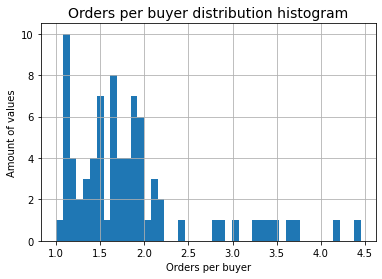

In [59]:
# revisar la distribucion 
cohort_orders.orders_per_buyer.hist(bins = 45)
plt.xlabel('Orders per buyer')
plt.ylabel('Amount of values')
plt.title('Orders per buyer distribution histogram', fontsize = 14)
plt.show()

In [60]:
# Mostrar el promedio total de pedidos por comprador durante un mes:
round(cohort_orders.orders_per_buyer.median(), 2)

1.68

In [61]:
# Pedidos por mes

orders_per_month = cohort_orders.pivot_table(
    index = 'first_order_month',
    columns = 'age_month',
    values = 'orders_per_buyer',
    aggfunc = 'sum')

orders_per_month.head(10)

age_month,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07-01,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08-01,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09-01,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10-01,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


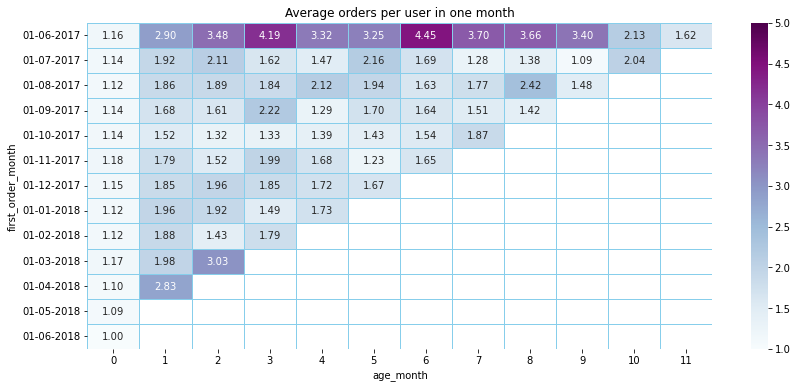

In [62]:
# mapa de calor que represente el Promedio de pedidos por usuario en un mes 

plt.figure(figsize=(14, 6))
plt.title('Average orders per user in one month')
sns.heatmap(
    orders_per_month, 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='skyblue', 
    cmap = 'BuPu',
    vmin = 1, vmax = 5
).set_yticklabels(orders_per_month.index.strftime('%d-%m-%Y'))
plt.show()

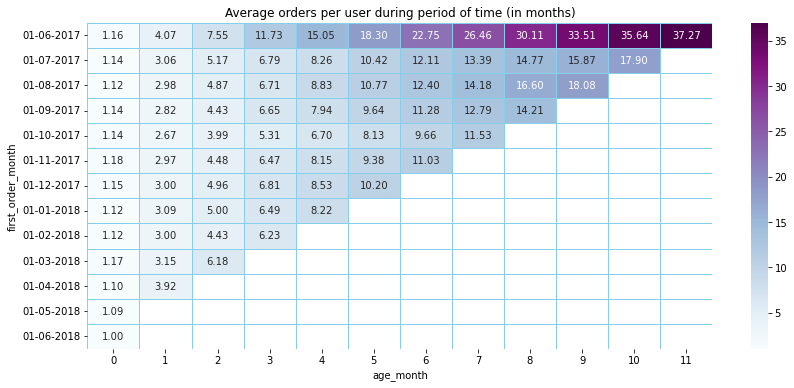

In [63]:
# Promedio de pedidos por usuario durante un período de tiempo (en meses), acomulativo 


plt.figure(figsize=(14, 6))
plt.title('Average orders per user during period of time (in months)')
sns.heatmap(
    orders_per_month.cumsum(axis = 1), 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='skyblue', 
    cmap = 'BuPu',
    vmin = 1, vmax = 37
).set_yticklabels(orders_per_month.index.strftime('%d-%m-%Y'))
plt.show()

In [64]:
# separate data for easier comparison by source and device
orders_split = order[['buy_ts', 'uid', 'revenue', 'order_month', 'first_order_month']]


In [65]:
# merge sources and devices columns from user_activity table
orders_split = orders_split.merge(
    user_activity.groupby('uid').agg({'first_device':'first', 'first_source_id':'first'}).reset_index(), 
    on = 'uid', how = 'left')

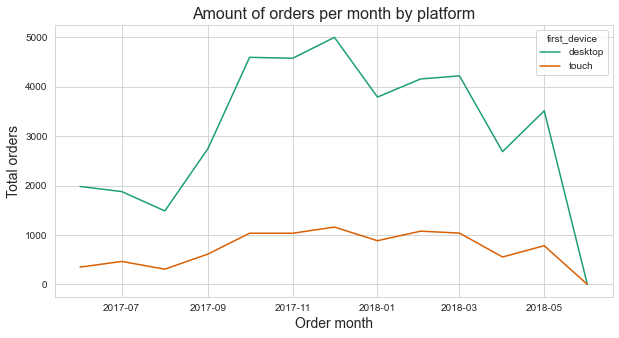

In [66]:
# Numero de pedidos  por dispositivo

orders_device = orders_split.groupby(['first_device', 'order_month']).agg({'buy_ts':'count'}).reset_index()

sns.set_style("whitegrid")
plt.figure(figsize = (10,5))
sns.lineplot(data = orders_device, x = 'order_month', y = 'buy_ts', hue = 'first_device', palette = 'Dark2')
plt.title('Amount of orders per month by platform', fontsize = 16)
plt.ylabel('Total orders', fontsize = 14)
plt.xlabel('Order month', fontsize = 14)
plt.show()

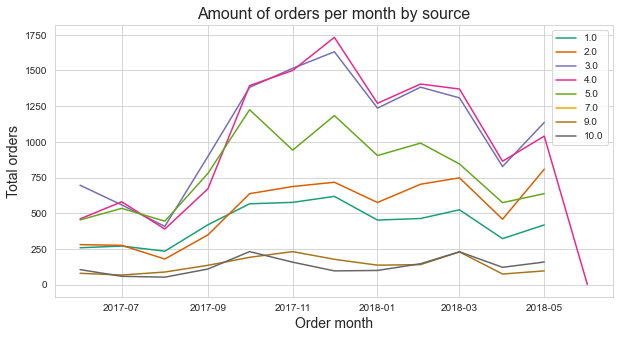

In [67]:
# numero de pedidos por anuncios 

orders_source = orders_split.groupby(['first_source_id', 'order_month']).agg({'buy_ts':'count'}).reset_index()

sns.set_style("whitegrid")
plt.figure(figsize = (10,5))
sns.lineplot(data = orders_source, x = 'order_month', y = 'buy_ts', hue = 'first_source_id', palette = 'Dark2').legend(loc = 1)
plt.title('Amount of orders per month by source', fontsize = 16)
plt.ylabel('Total orders', fontsize = 14)
plt.xlabel('Order month', fontsize = 14)
plt.show()

In [68]:
# create sources table for easier comparison (I prefer to look at all the relevant numbers concentrated in one table):
sources = pd.concat([conversion.groupby('first_source_id').conversion_days.median(), 
                    source_retention.groupby('first_source_id').retention.median()], axis = 1).merge(
    orders_source.groupby('first_source_id').agg({'buy_ts':'mean'}), on = 'first_source_id', how = 'outer').merge(
    visits_by_source, on = 'first_source_id', how = 'outer')

sources = sources.rename(columns = {'buy_ts':'orders_per_month'})


In [69]:
# mostrar el promedio de ordenes mensuales por la fuente de anuncio 
sources.sort_values('orders_per_month', ascending = False).round(2)

,first_source_id,conversion_days,retention,orders_per_month,visits_share
2,3.0,1.0,0.02,1081.50,0.27
3,4.0,0.0,0.01,975.08,0.29
4,5.0,0.0,0.01,792.67,0.19
1,2.0,4.0,0.03,534.58,0.12
0,1.0,1.0,0.03,426.67,0.07
6,9.0,15.0,0.04,136.92,0.03
7,10.0,0.0,0.01,130.17,0.03
5,7.0,0.0,0.03,1.00,0.00
8,6.0,NaN,1.00,NaN,0.00


##### **Conclusion General**

#### ¿Cuál es el tamaño promedio de compra?

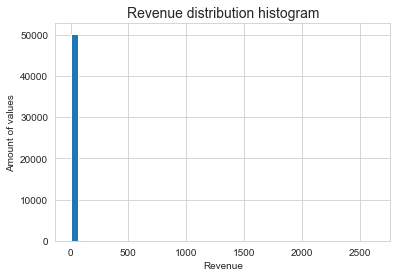

In [70]:
# revisar el tipo de distibucion para poder seleccionar la mediana o media
order.revenue.hist(bins = 40)
plt.xlabel('Revenue')
plt.ylabel('Amount of values')
plt.title('Revenue distribution histogram', fontsize = 14)
plt.show()

In [71]:
# Promedio del a suma de compras 

order.revenue.median()

2.5

In [72]:
# Crear cohortos:

cohort_purchases = order.dropna().pivot_table(
    index = 'first_order_month',
    columns = 'age_month',
    values = 'revenue',
    aggfunc = 'median')

# Agregamos una columna que calcule el promedio mensual de ingreso
cohort_purchases['average'] = cohort_purchases.median(axis = 1)
cohort_purchases

age_month,0,1,2,3,4,5,6,7,8,9,10,11,average
first_order_month,,,,,,,,,,,,,
2017-06-01,2.440,3.60,3.050,4.280,3.300,2.44,3.050,3.050,3.390,3.67,4.28,1.83,3.1750
2017-07-01,3.050,2.81,3.850,3.050,2.380,2.44,2.440,3.585,2.265,4.64,3.67,NaN,3.0500
2017-08-01,2.750,3.79,3.670,4.280,4.580,3.67,3.050,3.050,4.735,3.42,NaN,NaN,3.6700
2017-09-01,2.440,4.89,2.930,5.530,2.930,4.89,3.395,3.485,3.910,NaN,NaN,NaN,3.4850
2017-10-01,2.440,2.75,2.690,2.720,3.300,2.62,2.380,2.570,NaN,NaN,NaN,NaN,2.6550
2017-11-01,2.440,1.95,1.830,3.180,2.090,2.44,3.115,NaN,NaN,NaN,NaN,NaN,2.4400
2017-12-01,2.665,2.41,2.965,3.050,2.355,2.44,NaN,NaN,NaN,NaN,NaN,NaN,2.5525
2018-01-01,2.440,2.44,2.440,3.050,2.080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4400
2018-02-01,2.440,2.44,2.330,2.265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3850


<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
    
Perfecto, el cálculo del tamaño de compra es correcto.

</div>

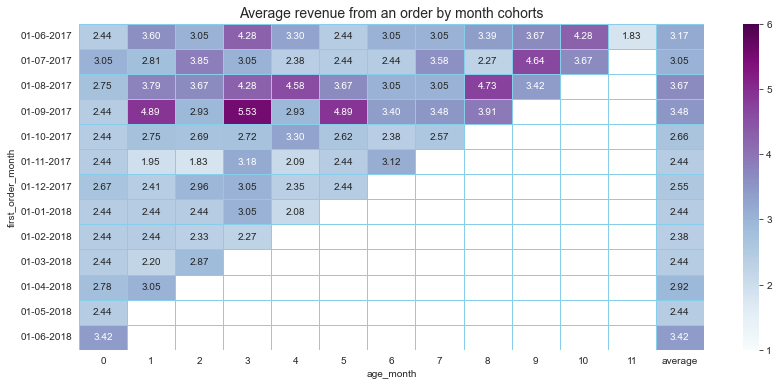

In [73]:
# Mapa de calor de ingresos promedio mensual por pedido para cohortes mensuales.

plt.figure(figsize=(14, 6))
plt.title('Average revenue from an order by month cohorts', fontsize = 14)
sns.heatmap(
    cohort_purchases, 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='skyblue', 
    cmap = 'BuPu',
    vmin = 1, vmax = 6
).set_yticklabels(orders_per_month.index.strftime('%d-%m-%Y'))
plt.show()

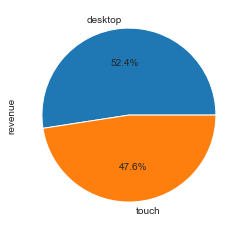

In [74]:
# Promedio de compra por dispositivo 
purchase_device = orders_split.groupby('first_device').agg({'revenue':'median'})
purchase_device.plot(kind = 'pie', subplots = 'True', autopct='%1.1f%%', legend = False)
plt.show()

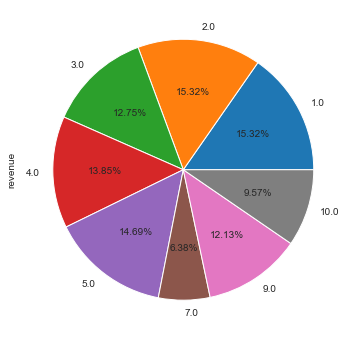

In [75]:
# Promedio de compra por fuente de anuncios 


purchase_source = orders_split.groupby('first_source_id').agg({'revenue':'median'})
purchase_source.plot(kind = 'pie', subplots = 'True', autopct='%.2f%%', legend = False, figsize = (6,6))
plt.show()

In [76]:
# Promedio mensual de comprar por fuente de trafico 


purchase_source_monthly = orders_split.pivot_table(
    index = 'first_source_id', 
    columns = 'order_month', 
    values = 'revenue', 
    aggfunc = 'median')

purchase_source_monthly.head(10)

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_source_id,,,,,,,,,,,,,
1.0,2.44,3.67,2.44,3.30,3.05,2.75,2.75,2.565,2.75,2.61,3.050,2.93,NaN
2.0,2.32,3.97,3.67,2.75,2.75,3.00,2.69,2.690,3.05,2.75,2.765,2.93,NaN
3.0,2.11,3.05,3.05,2.20,2.44,2.40,2.44,2.440,2.44,2.44,2.440,1.83,NaN
4.0,2.44,3.05,2.81,2.44,2.44,2.69,2.44,2.200,2.69,2.75,3.050,2.75,3.42
5.0,3.05,3.05,2.93,2.75,3.05,2.69,3.05,2.690,3.05,2.44,2.920,2.44,NaN
7.0,NaN,NaN,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,2.38,2.44,2.15,2.00,2.78,1.95,2.44,1.850,2.44,1.71,2.200,2.41,NaN
10.0,1.59,1.83,1.71,1.77,1.28,2.20,2.20,2.140,1.83,2.12,1.750,1.83,NaN


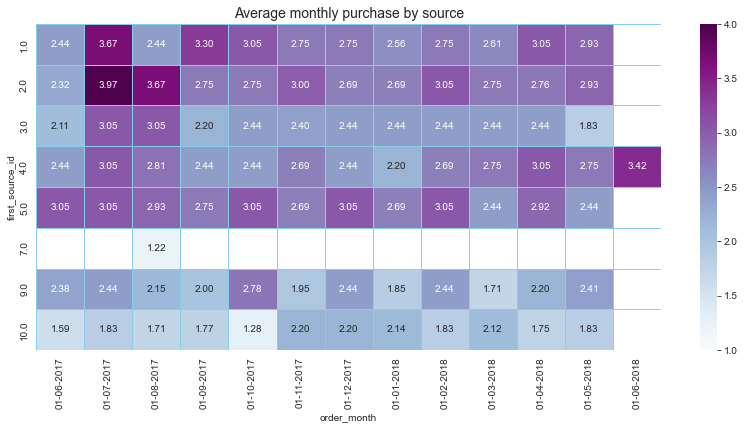

In [77]:
# Creamos el grafico 

plt.figure(figsize=(14, 6))
plt.title('Average monthly purchase by source', fontsize = 14)
sns.heatmap(
    purchase_source_monthly, 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='skyblue', 
    cmap = 'BuPu',
    vmin = 1, vmax = 4
).set_xticklabels(purchase_source_monthly.columns.strftime('%d-%m-%Y'))
plt.show()

In [78]:
# unir tablas 

sources = sources.merge(purchase_source, on = 'first_source_id', how = 'left')
sources = sources.rename(columns = {'revenue':'average_revenue'})
sources.sort_values('average_revenue', ascending = False)

,first_source_id,conversion_days,retention,orders_per_month,visits_share,average_revenue
0,1.0,1.0,0.025917,426.666667,0.070922,2.93
1,2.0,4.0,0.031991,534.583333,0.117226,2.93
4,5.0,0.0,0.011415,792.666667,0.187438,2.81
3,4.0,0.0,0.014460,975.076923,0.285376,2.65
2,3.0,1.0,0.016394,1081.500000,0.274846,2.44
6,9.0,15.0,0.042248,136.916667,0.034906,2.32
7,10.0,0.0,0.012756,130.166667,0.029170,1.83
5,7.0,0.0,0.032258,1.000000,0.000105,1.22
8,6.0,NaN,1.000000,NaN,0.000012,NaN


##### **Conclusion General**

- El tamaño de compra promedio es de 2.44
- Las compras más grandes fueron realizadas por los grupos 6-8.17 y por los compradores de las fuentes 1, 2 y 5
- El tamaño de compra en computadoras de escritorio es ligeramente mayor que en dispositivos táctiles, pero la diferencia no parece ser muy significativa

#### ¿Cuánto dinero traen? (LTV)

Hay que calcular el valor  que se espera que genere el cliente durante el tiempo que este permanezca activo. esto incluye los ingresos generados por el cliente, como los constos asociados a su adquisicion, retencion y servicio.

CAC: costo que se incurre para adquirir a un nuevo cliente

In [79]:
# agregar el número de nuevos compradores cada mes:

cohort_users = order.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_users = cohort_users.rename(columns = {'uid':'cohort_users'})
cohort_users

,first_order_month,cohort_users
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [80]:
# Creamos los cohortos 

ltv_cohorts = order.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum', 'age_month':'mean'}).reset_index()
ltv_cohorts = ltv_cohorts.rename(columns = {'revenue':'gross_profit'})
ltv_cohorts.head(5)


,first_order_month,order_month,gross_profit,age_month
0,2017-06-01,2017-06-01,9557.49,0.0
1,2017-06-01,2017-07-01,981.82,1.0
2,2017-06-01,2017-08-01,885.34,2.0
3,2017-06-01,2017-09-01,1931.30,3.0
4,2017-06-01,2017-10-01,2068.58,4.0


In [81]:
# Unimos ambas tablas cohort_users y ltv_cohorts

ltv_cohorts = ltv_cohorts.merge(cohort_users, on = 'first_order_month')

ltv_cohorts['ltv'] = ltv_cohorts['gross_profit'] / ltv_cohorts['cohort_users']

ltv_cohorts.head()

,first_order_month,order_month,gross_profit,age_month,cohort_users,ltv
0,2017-06-01,2017-06-01,9557.49,0.0,2023,4.724414
1,2017-06-01,2017-07-01,981.82,1.0,2023,0.485329
2,2017-06-01,2017-08-01,885.34,2.0,2023,0.437637
3,2017-06-01,2017-09-01,1931.30,3.0,2023,0.954671
4,2017-06-01,2017-10-01,2068.58,4.0,2023,1.022531


In [82]:
# Creamos tabla dinamica 
ltv_cohorts_pivot = ltv_cohorts.pivot_table(
    index = 'first_order_month',
    columns = 'age_month',
    values = 'ltv',
    aggfunc = 'mean')

ltv_cohorts_pivot.head()

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN


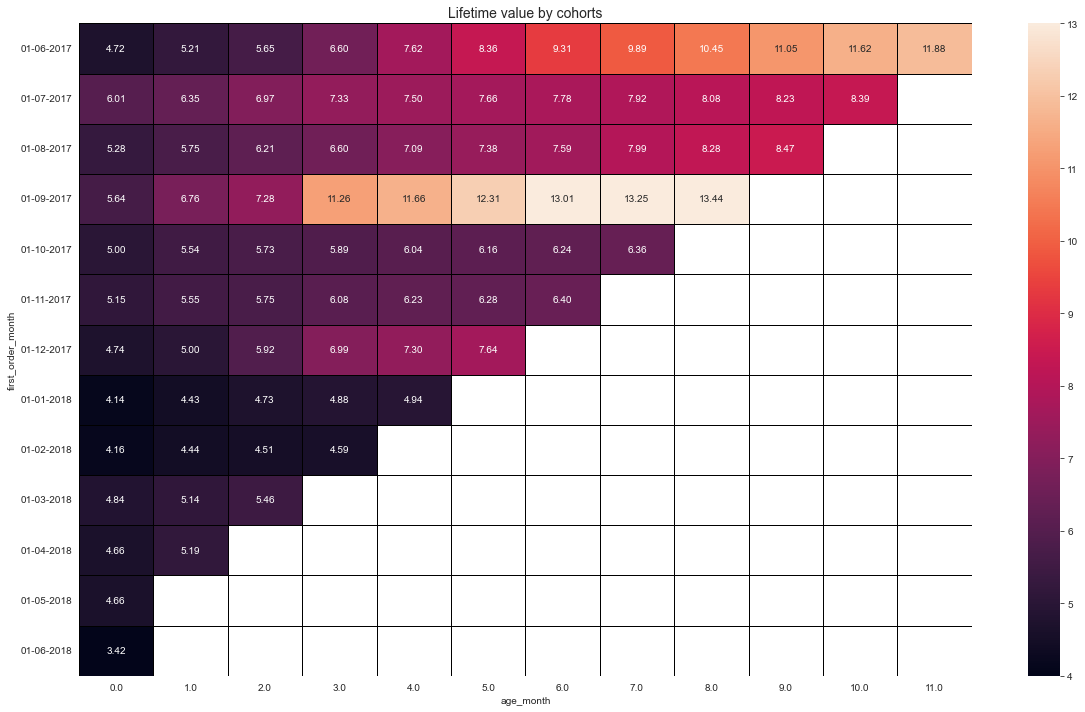

In [83]:
# Mapa de calor del  valor de vida útil por cohortes

plt.figure(figsize=(20, 12))
plt.title('Lifetime value by cohorts', fontsize = 14)
sns.heatmap(
    ltv_cohorts_pivot.cumsum(axis = 1), 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='black', 
    #cmap = 'BuPu',
    vmin = 4, vmax = 13
).set_yticklabels(orders_per_month.index.strftime('%d-%m-%Y'))
plt.show()

In [84]:
# revisar LTV por tipo de anuncio 

ltv_sources = orders_split.groupby(['first_source_id', 'order_month']).agg({'revenue':'sum'}).reset_index()
ltv_sources = ltv_sources.rename(columns = {'revenue':'gross_profit'})


source_users = orders_split.groupby('first_source_id').agg({'uid':'nunique'})
source_users = source_users.rename(columns = {'uid':'source_users'})

ltv_sources = ltv_sources.merge(source_users, on = 'first_source_id')

ltv_sources['ltv'] = ltv_sources['gross_profit'] / ltv_sources['source_users']

ltv_sources.head()

,first_source_id,order_month,gross_profit,source_users,ltv
0,1.0,2017-06-01,1326.73,2972,0.446410
1,1.0,2017-07-01,1613.18,2972,0.542793
2,1.0,2017-08-01,1418.18,2972,0.477180
3,1.0,2017-09-01,2869.19,2972,0.965407
4,1.0,2017-10-01,3534.07,2972,1.189122


In [85]:
# Tabla dinamica

ltv_sources_pivot = ltv_sources.pivot_table(
    index = 'first_source_id',
    columns = 'order_month',
    values = 'ltv',
    aggfunc = 'mean')

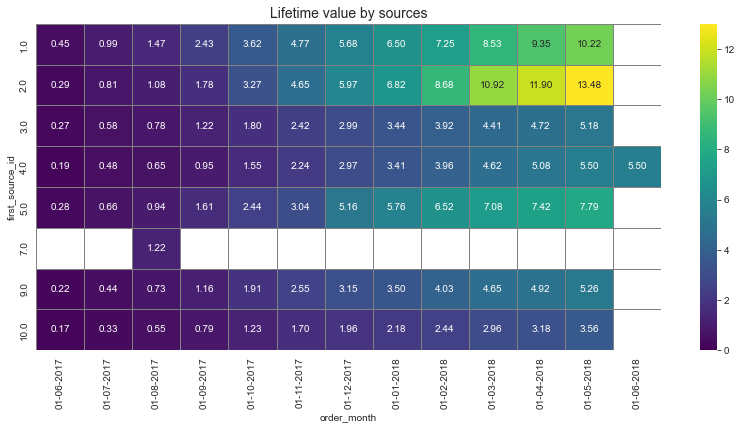

In [86]:
# Mapa de calor del valor de vida del cliente por fuentes


plt.figure(figsize=(14, 6))
plt.title('Lifetime value by sources', fontsize = 14)
sns.heatmap(
    ltv_sources_pivot.cumsum(axis = 1), 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='grey', 
    cmap = 'viridis',
    vmin = 0, vmax = 13
).set_xticklabels(ltv_sources_pivot.columns.strftime('%d-%m-%Y'))
plt.show()

In [87]:
sources = sources.merge(ltv_sources.groupby('first_source_id').ltv.mean().reset_index(), on = 'first_source_id', how = 'left')
sources.sort_values(by = 'ltv', ascending = False)

,first_source_id,conversion_days,retention,orders_per_month,visits_share,average_revenue,ltv
5,7.0,0.0,0.032258,1.000000,0.000105,1.22,1.220000
1,2.0,4.0,0.031991,534.583333,0.117226,2.93,1.123307
0,1.0,1.0,0.025917,426.666667,0.070922,2.93,0.851902
4,5.0,0.0,0.011415,792.666667,0.187438,2.81,0.649314
6,9.0,15.0,0.042248,136.916667,0.034906,2.32,0.438477
2,3.0,1.0,0.016394,1081.500000,0.274846,2.44,0.431514
3,4.0,0.0,0.014460,975.076923,0.285376,2.65,0.422975
7,10.0,0.0,0.012756,130.166667,0.029170,1.83,0.296697
8,6.0,NaN,1.000000,NaN,0.000012,NaN,NaN


In [88]:
# LTV   por plataforma :

ltv_devices = orders_split.groupby(['first_device', 'order_month']).agg({'revenue':'sum'}).reset_index()
ltv_devices = ltv_devices.rename(columns = {'revenue':'gross_profit'})

device_users = orders_split.groupby('first_device').agg({'uid':'nunique'})
device_users = device_users.rename(columns = {'uid':'device_users'})

ltv_devices = ltv_devices.merge(device_users, on = 'first_device')

ltv_devices['ltv'] = ltv_devices['gross_profit'] / ltv_devices['device_users']


In [89]:
# Tabla dinamica 

ltv_devices_pivot = ltv_devices.pivot_table(
    index = 'order_month',
    columns = 'first_device',
    values = 'ltv',
    aggfunc = 'mean')

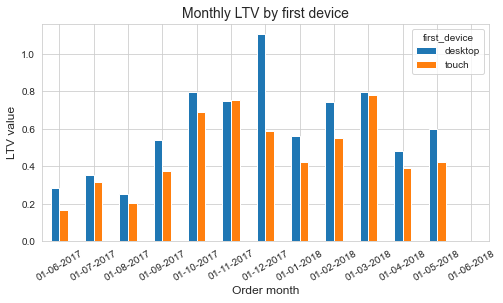

In [90]:
# Mensual LTV por primer dispositivo

ltv_devices_pivot.plot(kind = 'bar', figsize = (8,4), rot = 30).set_xticklabels(ltv_devices_pivot.index.strftime('%d-%m-%Y'))
plt.xlabel('Order month', fontsize = 12)
plt.ylabel('LTV value', fontsize = 12)
plt.title('Monthly LTV by first device', fontsize = 14)
plt.show()

##### **Conclusion General**

- El LTV más alto a lo largo del tiempo se observa para la primera cohorte (6.17). También se puede observar una conexión con la estacionalidad: durante las vacaciones de verano, el LTV aumenta para la mayoría de las cohortes.
- Las fuentes con el LTV más alto son 1, 2 y 5.
- Si observamos los dispositivos, el LTV es ligeramente más bajo para los dispositivos táctiles en cualquier mes dado.

### 03. Marketing 

In [91]:
cost.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


#### ¿Cuánto dinero se gastó? (Total/por fuente/a lo largo del tiempo)

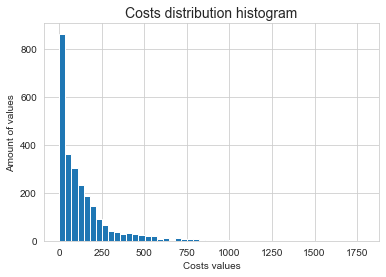

In [92]:
# Analisis de la distribucion de la tabla "cost"

cost.costs.hist(bins = 50)
plt.xlabel('Costs values')
plt.ylabel('Amount of values')
plt.title('Costs distribution histogram', fontsize = 14)
plt.show()

In [93]:
# Agregamos una columna de mes
cost['month'] = cost.dt.astype('datetime64[M]')

In [94]:
#Costo mensual 
cost_m = cost.groupby('month').agg({'costs':'sum'})
cost_m = cost_m.reset_index()
cost_m

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [95]:
#Ingreso mensual 

order_m= order.groupby('order_month').agg({'revenue': 'sum'})
order_m= order_m.reset_index()
order_m

,order_month,revenue
0,2017-06-01,9557.49
1,2017-07-01,12539.47
2,2017-08-01,8758.78
3,2017-09-01,18345.51
4,2017-10-01,27987.70
5,2017-11-01,27069.93
6,2017-12-01,36388.60
7,2018-01-01,19417.13
8,2018-02-01,25560.54
9,2018-03-01,28834.59


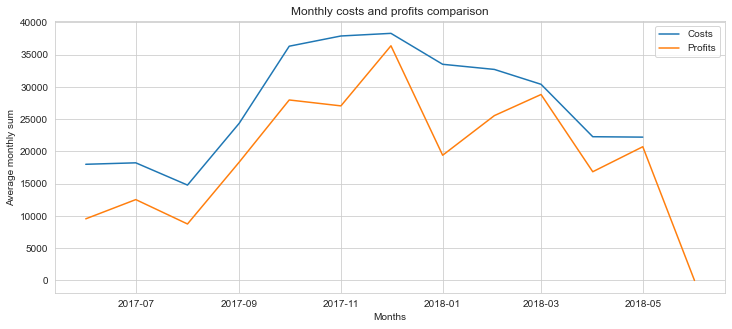

In [96]:

# comprar elc costo y pedidos
plt.figure(figsize = (12,5))

plt.plot(cost_m['month'],cost_m['costs'], label = 'Costs')

plt.plot(order_m['order_month'],order_m['revenue'], label = 'Profits')

plt.ylabel('Average monthly sum')
plt.xlabel('Months')
plt.title('Monthly costs and profits comparison')
plt.legend()
plt.show()

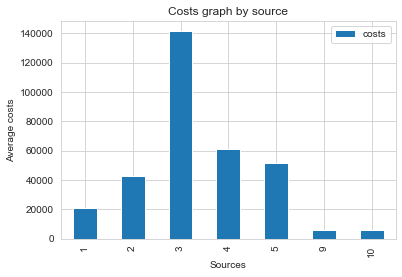

In [97]:
# Calculamos el costo de las diferentes fuentes de servicios 

cost.groupby('source_id').agg({'costs':'sum'}).plot(kind = 'bar')
plt.ylabel('Average costs')
plt.xlabel('Sources')
plt.title('Costs graph by source')
plt.show()

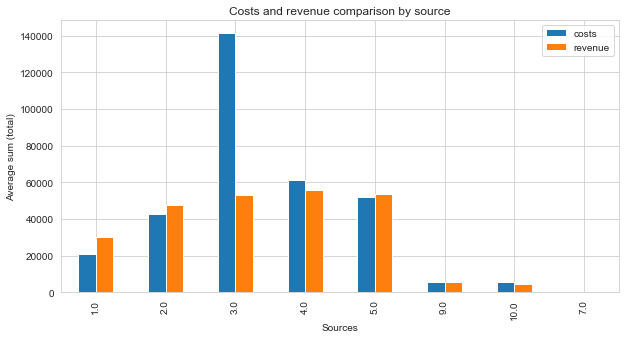

In [98]:
# graficamos la comparacion entre el los ingresos y costos para cada fuente 

pd.concat([cost.groupby('source_id').agg({'costs':'sum'}), 
           
         orders_split.groupby('first_source_id').agg({'revenue':'sum'})],
          
         axis = 1).plot(kind = 'bar', figsize = (10,5))

plt.ylabel('Average sum (total)')
plt.xlabel('Sources')
plt.title('Costs and revenue comparison by source')
plt.show()

In [99]:
# Juntamos tablas 

sources = sources.merge(cost.groupby('source_id').agg({'costs':'sum'}).reset_index(),
                        left_on = 'first_source_id', right_on = 'source_id', how = 'left')

In [100]:
sources.drop(columns = 'source_id', inplace = True)
sources.sort_values(by = 'costs', ascending = False)

,first_source_id,conversion_days,retention,orders_per_month,visits_share,average_revenue,ltv,costs
2,3.0,1.0,0.016394,1081.500000,0.274846,2.44,0.431514,141321.63
3,4.0,0.0,0.014460,975.076923,0.285376,2.65,0.422975,61073.60
4,5.0,0.0,0.011415,792.666667,0.187438,2.81,0.649314,51757.10
1,2.0,4.0,0.031991,534.583333,0.117226,2.93,1.123307,42806.04
0,1.0,1.0,0.025917,426.666667,0.070922,2.93,0.851902,20833.27
7,10.0,0.0,0.012756,130.166667,0.029170,1.83,0.296697,5822.49
6,9.0,15.0,0.042248,136.916667,0.034906,2.32,0.438477,5517.49
5,7.0,0.0,0.032258,1.000000,0.000105,1.22,1.220000,NaN
8,6.0,NaN,1.000000,NaN,0.000012,NaN,NaN,NaN


##### **Conclusion General**

- Los costos mensuales parecen estar influenciados por la estacionalidad, la mayoría de los gastos se realizan de octubre a marzo.<br>
- Los costos son significativamente más altos que las ganancias.
- La fuente con los mayores costos de marketing es el número 3.
- Las ganancias de las fuentes 1, 2 y 5 son ligeramente mayores que los costos.

#### ¿Cuánto costó la adquisición de clientes de cada una de las fuentes?

In [101]:
# aregamos el costo total por mes  
ltv_cohorts = ltv_cohorts.merge(cost.groupby('month').agg({'costs':'sum'}), 
                                left_on = 'first_order_month', right_on = 'month')

ltv_cohorts

,first_order_month,order_month,gross_profit,age_month,cohort_users,ltv,costs
0,2017-06-01,2017-06-01,9557.49,0.0,2023,4.724414,18015.00
1,2017-06-01,2017-07-01,981.82,1.0,2023,0.485329,18015.00
2,2017-06-01,2017-08-01,885.34,2.0,2023,0.437637,18015.00
3,2017-06-01,2017-09-01,1931.30,3.0,2023,0.954671,18015.00
4,2017-06-01,2017-10-01,2068.58,4.0,2023,1.022531,18015.00
...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,1063.05,1.0,3533,0.300892,30415.27
74,2018-03-01,2018-05-01,1114.87,2.0,3533,0.315559,30415.27
75,2018-04-01,2018-04-01,10600.69,0.0,2276,4.657597,22289.38
76,2018-04-01,2018-05-01,1209.92,1.0,2276,0.531599,22289.38


In [102]:
# Calculamos el CAC
ltv_cohorts['cac'] = ltv_cohorts['costs'] / ltv_cohorts['cohort_users']

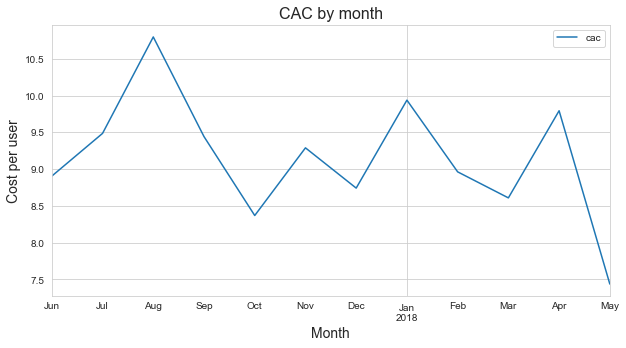

In [103]:
# Tabla dinamica 
ltv_cohorts_cac = ltv_cohorts.groupby('first_order_month').agg({'cac':'first'})

#Graficamos el comportamiento de cac 

ltv_cohorts_cac.plot(figsize = (10,5))
plt.title('CAC by month', fontsize = 16)
plt.ylabel('Cost per user', fontsize = 14)
plt.xlabel('Month', fontsize = 14)
plt.show()

In [104]:
ltv_sources = ltv_sources.merge(
    cost.groupby(['month', 'source_id']).costs.sum().reset_index(),
    left_on = (['order_month', 'first_source_id']),
    right_on = (['month', 'source_id']), how = 'left')

ltv_sources

,first_source_id,order_month,gross_profit,source_users,ltv,month,source_id,costs
0,1.0,2017-06-01,1326.73,2972,0.446410,2017-06-01,1.0,1125.61
1,1.0,2017-07-01,1613.18,2972,0.542793,2017-07-01,1.0,1072.88
2,1.0,2017-08-01,1418.18,2972,0.477180,2017-08-01,1.0,951.81
3,1.0,2017-09-01,2869.19,2972,0.965407,2017-09-01,1.0,1502.01
4,1.0,2017-10-01,3534.07,2972,1.189122,2017-10-01,1.0,2315.75
...,...,...,...,...,...,...,...,...
81,10.0,2018-01-01,291.20,1308,0.222630,2018-01-01,10.0,614.35
82,10.0,2018-02-01,335.20,1308,0.256269,2018-02-01,10.0,480.88
83,10.0,2018-03-01,681.76,1308,0.521223,2018-03-01,10.0,526.41
84,10.0,2018-04-01,286.16,1308,0.218777,2018-04-01,10.0,388.25


In [105]:
ltv_sources.drop(columns = ['source_id', 'month'], inplace = True)
ltv_sources.rename(columns = {'costs':'total_costs'}, inplace = True)

ltv_sources['cac'] = ltv_sources['total_costs'] / ltv_sources['source_users']
ltv_sources.head()

,first_source_id,order_month,gross_profit,source_users,ltv,total_costs,cac
0,1.0,2017-06-01,1326.73,2972,0.446410,1125.61,0.378738
1,1.0,2017-07-01,1613.18,2972,0.542793,1072.88,0.360996
2,1.0,2017-08-01,1418.18,2972,0.477180,951.81,0.320259
3,1.0,2017-09-01,2869.19,2972,0.965407,1502.01,0.505387
4,1.0,2017-10-01,3534.07,2972,1.189122,2315.75,0.779189


In [106]:
#Tabla dinamica para calcular cohortos 

cac_sources = ltv_sources.pivot_table(
    index = 'first_source_id',
    columns = 'order_month',
    values = 'cac',
    aggfunc = 'mean')

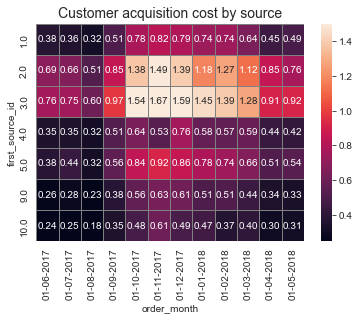

In [107]:
plt.title('Customer acquisition cost by source', fontsize = 14 )
sns.heatmap(
    cac_sources, 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='grey', 
    #cmap = 'BuPu',
    vmin = 0.25, vmax = 1.5
).set_xticklabels(cac_sources.columns.strftime('%d-%m-%Y'))
plt.show()

##### **Conclusion General**

- Los costos mensuales son más altos en enero y abril.
- El CAC por fuente es más alto para las fuentes 2 y 3, con las fuentes 5 y 1 siguiendo.

#### ¿Cuán rentables eran las inversiones? (ROI)

In [108]:
# Calculamos el ROI por cohorto
ltv_cohorts['romi'] = ltv_cohorts['ltv'] / ltv_cohorts['cac']

# Creamos una tabla dinamica 

romi_cohorts = ltv_cohorts.pivot_table(
    index = 'first_order_month',
    columns = 'age_month',
    values = 'romi',
    aggfunc = 'mean')

romi_cohorts

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,0.530530,0.054500,0.049145,0.107205,0.114825,0.082593,0.106730,0.065310,0.062123,0.068027,0.064150,0.028844
2017-07-01,0.633623,0.035339,0.065735,0.037845,0.018638,0.016451,0.012673,0.014951,0.016998,0.015513,0.016412,NaN
2017-08-01,0.488747,0.043719,0.042468,0.036243,0.045762,0.026263,0.019513,0.037515,0.027067,0.017412,NaN,NaN
2017-09-01,0.597833,0.118368,0.055174,0.421091,0.042425,0.068533,0.074310,0.025753,0.019489,NaN,NaN,NaN
2017-10-01,0.597866,0.064015,0.022869,0.018776,0.018109,0.014381,0.010134,0.013797,NaN,NaN,NaN,NaN
2017-11-01,0.554931,0.042980,0.021483,0.034983,0.015934,0.005800,0.012373,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.542015,0.029785,0.105824,0.121860,0.035797,0.038670,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.416173,0.029662,0.030620,0.014368,0.006309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.463807,0.031048,0.008760,0.008272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


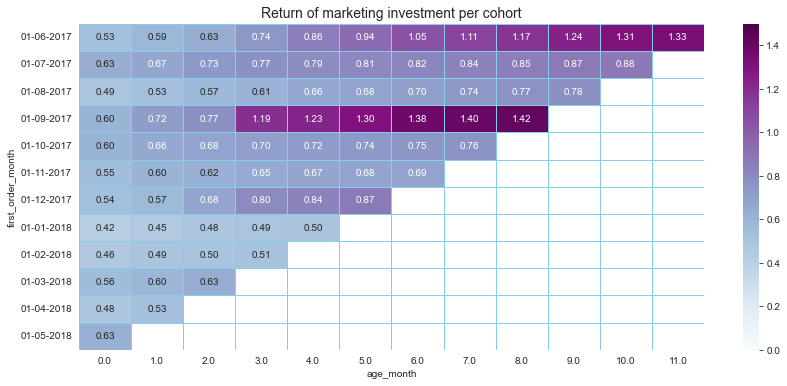

In [109]:
# representamos los valores con un mapa de calor 


plt.figure(figsize=(14, 6))
plt.title('Return of marketing investment per cohort', fontsize = 14)
sns.heatmap(
    romi_cohorts.cumsum(axis = 1), 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='skyblue', 
    cmap = 'BuPu',
    vmin = 0, vmax = 1.5
).set_yticklabels(romi_cohorts.index.strftime('%d-%m-%Y'))
plt.show()

In [110]:
# promedio de ROMI por tipo de anuncio 

ltv_sources['romi'] = ltv_sources['ltv'] / ltv_sources['cac']

ltv_sources.head()

,first_source_id,order_month,gross_profit,source_users,ltv,total_costs,cac,romi
0,1.0,2017-06-01,1326.73,2972,0.446410,1125.61,0.378738,1.178676
1,1.0,2017-07-01,1613.18,2972,0.542793,1072.88,0.360996,1.503598
2,1.0,2017-08-01,1418.18,2972,0.477180,951.81,0.320259,1.489982
3,1.0,2017-09-01,2869.19,2972,0.965407,1502.01,0.505387,1.910234
4,1.0,2017-10-01,3534.07,2972,1.189122,2315.75,0.779189,1.526102


In [111]:
# Tabla dinamica 

romi_source = ltv_sources.pivot_table(
    index = 'first_source_id',
    columns = 'order_month',
    values = 'romi',
    aggfunc = 'mean')



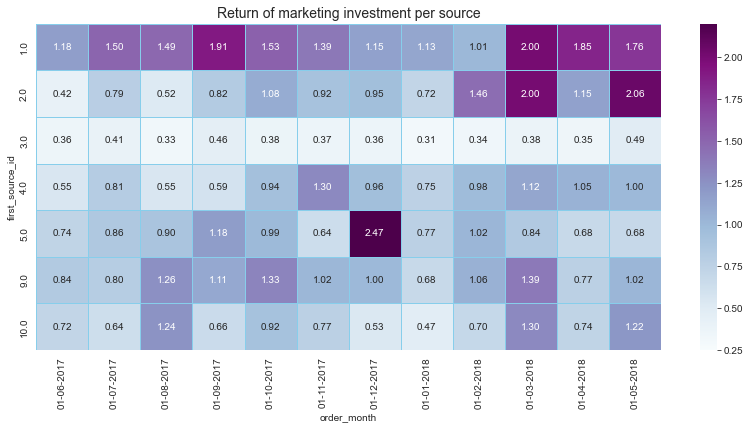

In [112]:
# Graficar el retorno de la inversión en marketing por fuente
plt.figure(figsize=(14, 6))
plt.title('Return of marketing investment per source', fontsize = 14)
sns.heatmap(
    romi_source, 
    annot=True, 
    fmt='.2f', 
    linewidths=1, 
    linecolor='skyblue', 
    cmap = 'BuPu',
    vmin = 0.25, vmax = 2.2
).set_xticklabels(romi_source.columns.strftime('%d-%m-%Y'))
plt.show()

##### **Conclusion General**

- El mayor ROMI se observa en las cohortes 6.17 y 9.17, seguido por las cohortes 7.17 y 12.17.
- Las fuentes con el mejor retorno de inversión en marketing son 1, 2 y 5.

## 04 . Conclusion del Proyecto 

En este proyecto se revisó lasdiferentes indicadores y calculé métricas para evaluar la efectividad de la estrategia de marketing en el período de informe. Para esta tarea ordené los datos por diferentes criterios: cohortes de usuarios por fecha de su incorporación, usuarios cuya primera visita fue desde fuentes específicas y usuarios que comenzaron a usar el servicio en diferentes plataformas. Revisé tanto los datos generales para verificar los promedios totales como la dinámica durante un período de tiempo para rastrear patrones estacionales.

En general, los costos son muy altos mientras que las ganancias no son lo suficientemente altas como para cubrirlos.

Basándonos en los hallazgos anteriores, creo que la mejor opción es hacer lo siguiente:

- Reducir los gastos de marketing en enero; su momento coincide con la caída en la actividad de los usuarios y la disminución estacional de las ventas, lo que trae el retorno de inversión más bajo. En cuanto al mes, prestaría más atención a junio y septiembre, ya que los usuarios atraídos en esos meses fueron los más activos en el transcurso del año, realizaron muchas compras, tienen una suma de compra superior al promedio y excelentes tasas de LTV y ROMI.

- Se detecta la mayor actividad de los usuarios en el período justo antes de las vacaciones de invierno. Sin embargo, incluso en este período, los gastos son mayores que los ingresos, y deben optimizarse.

- La fuente número tres tiene costos muy altos en comparación con los ingresos, lo que conduce a un retorno de inversión relativamente bajo. Aunque trae muchos clientes (la fuente 3 lidera en cantidad de clientes en general) y es la segunda en número de compras, la cantidad promedio de compra para esta fuente es menor que el promedio total y el LTV es correspondientemente bajo. Creo que la misma cantidad de dinero invertida en otras fuentes podría dar mejores beneficios.

- Las fuentes 1 y 2, aunque tienen una participación relativamente pequeña de clientes (7% y 12% respectivamente), son las que generan las mejores ganancias. El ingreso promedio por venta de esos clientes es el más alto (2.9, en comparación con 2.3 en la fuente 3), por lo que su LTV y ROMI son correspondientemente altos. Recomendaría prestar más atención a esas fuentes.

- La fuente 5 es la última en la que las ganancias son mayores que los costos. Si bien las inversiones en marketing en esta fuente generan menos ingresos por cliente que en las fuentes 1 y 2, aún genera ingresos y no pérdidas, por lo que lo veo como otra fuente potencial de mayores ganancias.

-  La fuente 7 tiene valores excelentes, mejores que en cualquier otra fuente, en casi todas las métricas "por cliente", pero tengo relativamente pocos datos sobre esta fuente (0.01% del conjunto de datos completo) y no la considero lo suficientemente confiable.

También me gustaría señalar la baja actividad de los usuarios en dispositivos táctiles. Tienen visitas demasiado escasas, esas visitas son más cortas y las tasas de retención también son peores. El gráfico de cantidad de pedidos muestra que el comportamiento de compra de esos usuarios está mucho menos afectado por la estacionalidad (y por las inversiones estacionales en marketing, en consecuencia). Dado que la mayoría de los usuarios, según cualquier encuesta confiable, prefieren usar dispositivos móviles en lugar de computadoras de escritorio, es obvio que el servicio está pasando por alto un gran segmento de usuarios y las ganancias que podrían generar.